# 1. Pre-processing
### 1.1. Imports and Setting the path

In [2]:
IMAGE_SIZE = [224, 224]
PATH = '/home/dilara/UGI-endoscopy/images'
CLASSES = ['pylorus', 'retroflex-stomach', 'z-line', 'other']

import keras
from keras.utils import np_utils
from keras.layers import Dense, Flatten 
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import skimage
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sbs
from PIL import Image

## setting the paths
all_paths = []
len_lis = []
for landmark in CLASSES:
    other_path = os.path.join(PATH, landmark, '*')
    all_paths.append(sorted(glob.glob(other_path)))
# all_paths = list(np.concatenate(all_paths).flat)

## finding the number of image per class
for lis in all_paths:
    x = 0
    for item in lis:
        x+=1
    print(x)
    len_lis.append(x)
print(len_lis)

all_paths = list(np.concatenate(all_paths).flat)

# df = pd.read_csv('file-names/filtered-names/numbered-labels.csv')
# all_labels = df['Finding'].to_numpy()

# # pylorus_labels = all_labels[0:5]
# # retroflex_stomach_labels = all_labels[999:1004]
# # zline_labels = all_labels[1763:1768]
# # other_labels = all_labels[2695:2700]

pylorus_labels = [1] * len_lis[0]
retroflex_stomach_labels = [3] * len_lis[1]
zline_labels = [2] * len_lis[2]
other_labels = [0] * len_lis[3]
all_labels = list(np.concatenate([pylorus_labels, retroflex_stomach_labels,
 zline_labels, other_labels]).flat)
all_labels = np.array(all_labels)

2022-04-03 21:29:53.031401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 21:29:53.031418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


6993
5348
6524
5299
[6993, 5348, 6524, 5299]


## 1.2. Data Augmentation

In [2]:
# for path in all_paths:
# 	file_name = path[:len(path)-4]
# 	file_name = file_name[:len(file_name)-4]
# 	image = cv2.imread(path)
# 	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 	rows, cols, dim = image.shape

# 	# flipping images upside down and leftright
# 	image_fliplr = np.fliplr(image)
# 	image_flipud = np.flipud(image)
# 	plt.imsave(f'{path}_image_flipud.jpg', image_flipud)
# 	plt.imsave(f'{path}_image_fliplr.jpg', image_fliplr)

# 	# rotating image
# 	rotated_img = skimage.transform.rotate(image, 90)
# 	plt.imsave(f'{path}_rotated_img.jpg', rotated_img)

# 	# shear transform on x-axis
# 	M = np.float32([[1, 0.7, 0],
# 					[0, 1  , 0],
# 					[0, 0  , 1]])             
# 	sheared_img = cv2.warpPerspective(image,M,(int(cols*1.5),int(rows*1.5)))
# 	plt.imsave(f'{path}_sheared_img.jpg', sheared_img)

# 	## zoom out
# 	M = np.float32([[1.5, 0  , 0],
# 					[0,   1.5, 0],
# 					[0,   0,   1]])
# 	scaledin_img = cv2.warpPerspective(image,M,(cols,rows))
# 	plt.imsave(f'{path}_scaledin_img.jpg', scaledin_img)

# 	M = np.float32([[0.8, 0  , 0],
# 					[0,   0.8, 0],
# 					[0,   0,   1]])
# 	scaledout_img = cv2.warpPerspective(image,M,(cols,rows))
# 	plt.imsave(f'{path}_scaledout_img.jpg', scaledout_img)

## 1.3. Splitting the Dataset

In [3]:
# storing pixel and label information
new_paths = []
count = 0
for landmark in CLASSES:
    other_path = os.path.join(PATH, landmark, '*')
    new_paths.append(sorted(glob.glob(other_path)))
    count += 1
new_paths = list(np.concatenate(new_paths).flat)
print(count)

# def count_files(i):
#     count = 0
#     # Iterate directory
#     for path in other_path[i]:
#         # check if current path is a file
#         if os.path.isfile(os.path.join(, path)):
#             count += 1
# print('File count:', count)
# count_files(0)

# pylorus_labels = [1] * 35
# retroflex_stomach_labels = [3] * 35
# zline_labels = [2] * 35
# other_labels = [0] * 35
# all_labels = list(np.concatenate([pylorus_labels, retroflex_stomach_labels,
#  zline_labels, other_labels]).flat)
# all_labels = np.array(all_labels)

# pylorus_labels = [1] * len_lis[0]
# retroflex_stomach_labels = [3] * len_lis[1]
# zline_labels = [2] * len_lis[2]
# other_labels = [0] * len_lis[3]
# all_labels = list(np.concatenate([pylorus_labels, retroflex_stomach_labels,
#  zline_labels, other_labels]).flat)
# all_labels = np.array(all_labels)

pix = []
for path in new_paths:
    file_name = path.split('/')[-1]
    image = cv2.imread(path)
    image_data = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    pix.append(image_data)

pix = np.array(pix)
print(len(pix))
pix_train, pix_val, label_train, label_val = train_test_split(pix, all_labels, train_size=0.75, random_state = 42)
label_train = keras.utils.np_utils.to_categorical(label_train, num_classes=4)
label_val = keras.utils.np_utils.to_categorical(label_val, num_classes=4)
print(pix_train.shape)

4
24164
(18123, 224, 224, 3)


# 2. Building the Model

In [4]:
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train the existing weights
for layer in vgg.layers:
 layer.trainable = False
 
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model.summary()

2022-04-03 21:40:43.694767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-03 21:40:43.694828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-03 21:40:43.694859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-03 21:40:43.706985: W tensorflow/stream_executor/platform

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 3. Training the Model

In [6]:
history = model.fit(pix_train, label_train, batch_size=64, epochs=10, validation_data=(pix_val, label_val))

Epoch 1/10
284/284 [==============================] - 453s 2s/step - loss: 0.4925 - accuracy: 0.9690 - val_loss: 4.3286 - val_accuracy: 0.8744
Epoch 2/10
284/284 [==============================] - 448s 2s/step - loss: 0.3942 - accuracy: 0.9735 - val_loss: 5.9107 - val_accuracy: 0.8687
Epoch 3/10
284/284 [==============================] - 443s 2s/step - loss: 0.4676 - accuracy: 0.9720 - val_loss: 5.4058 - val_accuracy: 0.8687
Epoch 4/10
284/284 [==============================] - 444s 2s/step - loss: 0.4742 - accuracy: 0.9731 - val_loss: 5.2867 - val_accuracy: 0.8724
Epoch 5/10
284/284 [==============================] - 442s 2s/step - loss: 0.4041 - accuracy: 0.9756 - val_loss: 5.6050 - val_accuracy: 0.8742
Epoch 6/10
284/284 [==============================] - 445s 2s/step - loss: 0.3780 - accuracy: 0.9784 - val_loss: 6.0782 - val_accuracy: 0.8710
Epoch 7/10
284/284 [==============================] - 448s 2s/step - loss: 0.4158 - accuracy: 0.9778 - val_loss: 7.5718 - val_accuracy: 0.8694

## 3.1. Plotting Model History

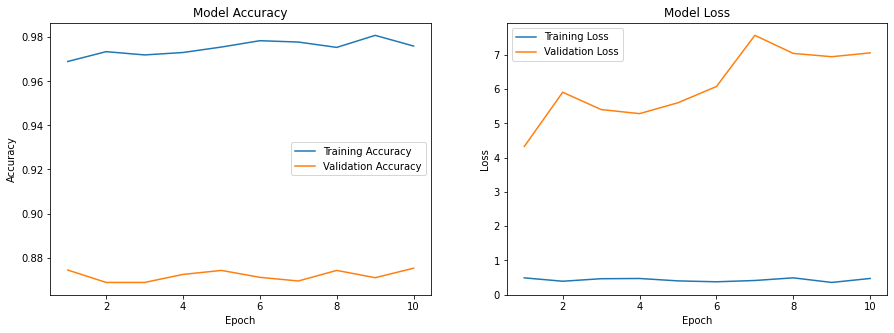

In [7]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarizing history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    
    # Summarizing history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Loss', 'Validation Loss'], loc='best')
    plt.show()

plot_model_history(history)

# 4. Output Prediction and Evaluation

In [8]:
label_predict = model.predict(pix_val)
# print(label_predict)
label_predict = np.argmax(model.predict(pix_val), axis=1)  # returns class values between 0 and 3 from highest prediction
# print(label_predict)
label_true = np.argmax(label_val, axis=1) 
# print(label_true)

target_names = ['other (0)', 'pylorus (1)', 'z-line (2)','retroflex-stomach (3)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=target_names))

Classification report:
                        precision    recall  f1-score   support

            other (0)       0.74      0.72      0.73      1332
          pylorus (1)       0.99      0.97      0.98      1777
           z-line (2)       0.76      0.80      0.78      1595
retroflex-stomach (3)       1.00      0.99      0.99      1337

             accuracy                           0.88      6041
            macro avg       0.87      0.87      0.87      6041
         weighted avg       0.88      0.88      0.88      6041



### 4.1. Confusion Matrix

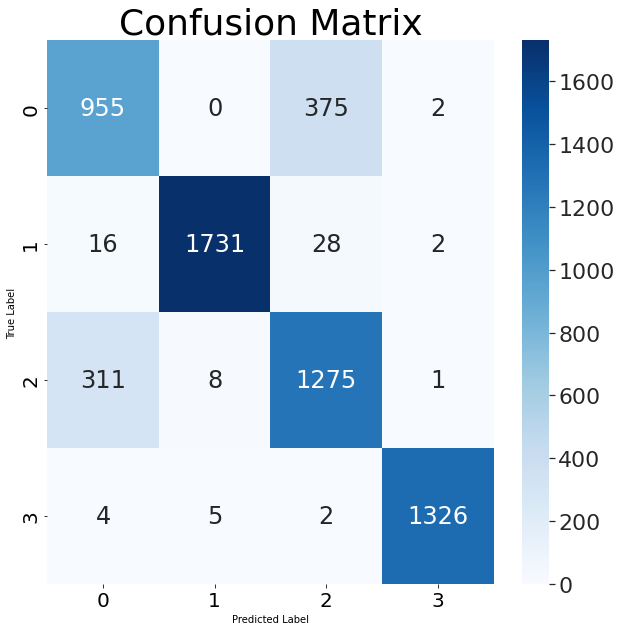

In [9]:
# Evaluating the CNN model by creating a confusion matrix
cm = confusion_matrix(label_true, label_predict)

plt.figure(figsize=(10,10))
ax = plt.subplot()

sbs.set(font_scale=2) 
sbs.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

title_font = {'size':'36'}  
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.xaxis.set_ticklabels(['0', '1', '2','3']);
ax.yaxis.set_ticklabels(['0', '1', '2','3']);
plt.show()